<a class="anchor" id="0.1"></a>
# **Table of Contents**
1. [Introduction](#1)
2. [Changelog](#2)
3. [Business Understanding](#3)
4. [Data Understanding](#4)
5. [Data Preperation](#5)
6. [Modeling](#6)
7. [Evaluation](#7)
8. [Improvements](#8)
9. [Conclusion](#9)

# **1. Introduction** <a class="anchor" id="1"></a>
[Table of Contents](#0.1)

This notebook will explore Support Vector Machine by going through the CRISP-DM process. The goal is to gain insight of how to use SVM in Python and their usefulness. This notebook will be borrowing from Anand Prabhakar's notebook [Python-Support-vector-machines](https://github.com/ipython-books/cookbook-2nd-code/blob/master/chapter08_ml/05_svm.ipynb) on the same topic. I highly recommend you read his notebook.

# **2. Changelog** <a class="anchor" id="2"></a>
[Table of Contents](#0.1)

# **3. Business Understanding** <a class="anchor" id="3"></a>
[Table of Contents](#0.1)

The dataset I will be using for this notebook is the [Apple Quality](https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality). Each record represents an apple with its quality labeled as good or bad.

For each apple, there are the following labels:
- Size: Size of the fruit
- Weight: Weight of the fruit
- Sweetness: Degree of sweetness of the fruit
- Crunchiness: Texture indicating the crunchiness of the fruit
- Juiciness: Level of juiciness of the fruit
- Ripeness: Stage of ripeness of the fruit
- Acidity: Acidity level of the fruit

For our purposes, we likely want to pick two of these labels to train our model on, as SVMs tends to work best with 2 dimensional data. Since our goal is to categorize the apples as good or bad quality, it is likely that ripeness will be a good label to make this prediction. However we may want to experiment with the other labels to determine which one is best to train the model.

# **4. Data Understanding** <a class="anchor" id="4"></a>
[Table of Contents](#0.1)

We will now explore our dataset to understand what type of data we are working with. First, we must import our dataset into python.

In [2]:
# This library will help us access our file
try:
    import os
except:
    !pip install os
    import os
    
# This library is for data processing, and CSV file I/O
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

In [3]:
current_working_directory = os.getcwd()
file = r'\input\apple_quality.csv' #this directory may differ for you
data = current_working_directory + file

df = pd.read_csv(data, header=0,sep=',')

Now that we've imported our data, we can explore it to gain insights

In [4]:
df.shape

(4001, 9)

This tells us that there are 4001 instance, and 17 attributes in our dataset.

In [5]:
df.head() #preview the top 5 rows

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [6]:
df.info() #summary of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


From the summary, we can see there are missing values. However, there's a single missing value for each label except for one. If were lucky, this will be a single record we can ommit from the dataset. We will explore this further during our data preperation stage.

### Explore Categorical Variables

In [7]:
# identify categorical variables

categorical = [var for var in df.columns if df[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables\n')
print(f'The categorical variables are: {categorical}')

There are 2 categorical variables

The categorical variables are: ['Acidity', 'Quality']


However, all of our labels with the exception of quality should be numerical values. Looking at the summary of the data we can see the acidity is of type object. We'll need to convert the data to a numerical value during data preperation.

### Explore Numerical Variables

In [8]:
# identify numerical variables

numerical = [var for var in df.columns if df[var].dtype!='O']

print(f'There are {len(numerical)} numerical variables\n')
print(f'The numerical variables are: {numerical}')

There are 7 numerical variables

The numerical variables are: ['A_id', 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness']


# **5. Data Preperation** <a class="anchor" id="5"></a>
[Table of Contents](#0.1)

During Data Understanding, we noticed there are some missing variables. There is also one label of type object that should be numerical. In this section we will handle for missing data, remove unecessary labels, as well as converting data types to the correct type.

In [9]:
df[numerical].isnull().sum()

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
dtype: int64

Here we can see there are null values for each category. Next we will remove all null values and check again.

In [10]:
df.dropna(inplace=True) # remove all null values from the dataframe
df[numerical].isnull().sum()

A_id           0
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
dtype: int64

Next we will drop the `A_id` column as it's not needed for our purposes.

In [11]:
df.drop('A_id', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   object 
 7   Quality      4000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 281.2+ KB


Next, I will change the datatype of the Acidity label from object to float64

In [12]:
df['Acidity'] = pd.to_numeric(df['Acidity'], errors='coerce', downcast='float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float32
 7   Quality      4000 non-null   object 
dtypes: float32(1), float64(6), object(1)
memory usage: 265.6+ KB


Now that we've converted the Acidity label to a float, we want to reassign our numerical and categorical variables

In [13]:
numerical = [var for var in df.columns if df[var].dtype!='O']
categorical = [var for var in df.columns if df[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables\n')
print(f'The categorical variables are: {categorical}\n\n')

print(f'There are {len(numerical)} numerical variables\n')
print(f'The numerical variables are: {numerical}')

There are 1 categorical variables

The categorical variables are: ['Quality']


There are 7 numerical variables

The numerical variables are: ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']


Next, we're goin to plot our apples and try different label combinations to see if we can find one that cleanly separates our good apples from our bad apples.

In [16]:
%matplotlib inline 

# This library is for plotting our data in a chart
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

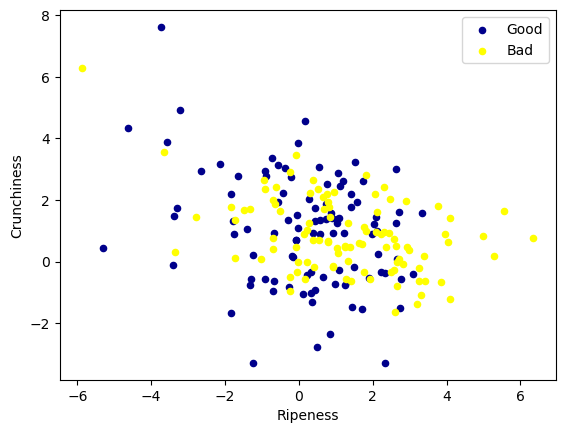

In [29]:
x_axis = 'Ripeness'
y_axis = 'Crunchiness'

ax = df[df['Quality'] == 'good'][0:100].plot(kind='scatter', x=x_axis, y=y_axis, color='DarkBlue', label='Good');
df[df['Quality'] == 'bad'][0:100].plot(kind='scatter', x=x_axis, y=y_axis, color='Yellow', label='Bad', ax=ax);
plt.show()

From the chart above, we can tell that the good and bad apples are not cleanly separated. In fact, even looking at just the `Ripeness`, it does not seem to be a good indicator of whether an apple is good or bad as we initially assumed. Next we will try different combinations of labels to see if we can find one that separates our data cleanly enough for the SVM.

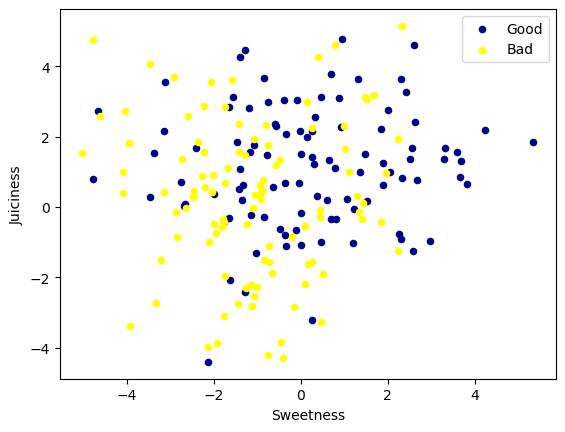

In [35]:
#sweetness
#Juiciness?
x_axis = 'Sweetness'
y_axis = 'Juiciness'

ax = df[df['Quality'] == 'good'][0:100].plot(kind='scatter', x=x_axis, y=y_axis, color='DarkBlue', label='Good');
df[df['Quality'] == 'bad'][0:100].plot(kind='scatter', x=x_axis, y=y_axis, color='Yellow', label='Bad', ax=ax);
plt.show()

`Sweetness` vs `Juiciness` seems like an improvement for our purposes. 

# **6. Modeling** <a class="anchor" id="6"></a>
[Table of Contents](#0.1)

# **7. Evaluation** <a class="anchor" id="7"></a>
[Table of Contents](#0.1)

# **8. Improvements** <a class="anchor" id="8"></a>
[Table of Contents](#0.1)

# **9. Conclusion** <a class="anchor" id="9"></a>
[Table of Contents](#0.1)